!! 증강 문제 있어서 바꿔야 함. -> 너무 오래 걸림

3개의 feature map 생성 -> pixel wise cross entropy
=> pixel wise cross entropy loss 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D, Dense, UpSampling2D, Flatten, Reshape,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2
import random
import re

2025-11-26 13:45:49.342506: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 13:45:49.349547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764132349.358359  827289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764132349.361147  827289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764132349.367761  827289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Dataset/config
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
print("TensorFlow Version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.1
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
class_name = {'gl':'glioma' , 'me':'meningioma','no': 'no_tumor', 'pi':'piruitary' }
print(list(class_name.keys())[0])

'/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task/test/images/brisc2025_test_00005_gl_ax_t1.jpg'
a=re.search(r'_([a-z]{2})_','/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task/test/images/brisc2025_test_00005_gl_ax_t1.jpg')
print(a.group(1))

gl
gl


In [4]:
#trying our basic unet for segmentation

import glob
from sklearn.model_selection import train_test_split

img_width=224  #128
img_height=224  #128
img_channels=3
class_name = {'gl':'glioma' , 'me':'meningioma','no': 'no_tumor', 'pi':'piruitary' }
# changed
base_path='/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task'

train_image_path= os.path.join(base_path,'train/images')
train_mask_path= os.path.join(base_path,'train/masks')
test_image_path= os.path.join(base_path,'test/images')
test_mask_path= os.path.join(base_path,'test/masks')

def load_preprocess(image_dir, mask_dir):
  image_files=sorted(glob.glob(os.path.join(image_dir, '*.*')))
  mask_files=sorted(glob.glob(os.path.join(mask_dir, '*.*')))
  if len(image_files) != len(mask_files):
    print(f"Error: Mismatch in file counts")
    print(f"Images found: {len(image_files)}, masks found = {len(image_files)}")
    return None, None
  X= []
  Y=[]
  print(f"Loading{len(image_files)}images and masks..")

  for img_path, mask_path in zip(image_files, mask_files):
    try:
      img=cv2.imread(img_path, cv2.IMREAD_COLOR)
      img=cv2.resize(img, (img_width, img_height))
      img=img/255.0
      #glioma-gl , meningioma-me, no_tumor-no, piruitary -pi 
      mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask=cv2.resize(mask,(img_width, img_height))

      class_match = re.search(r'_([a-z]{2})_',mask_path)
      str1 = class_match.group(1)
      mask_3ch = np.zeros((img_width, img_height, 3), dtype=np.uint8)
      match str1:
        case 'gl' :
          mask_3ch[:, :, 0] = mask[:, :]
        case 'me':
          mask_3ch[:, :, 1] = mask[:, :]
        case 'pi':
          mask_3ch[:, :, 2] = mask[:, :]
        case 'no':
          pass
      
      mask_3ch=(mask_3ch>128).astype(np.float32)
      X.append(img)
      Y.append(mask_3ch)
    except Exception as e:
     print(f"Error loading image or mask: {e}")

  X=np.array(X)
  Y=np.array(Y)
  #Y=np.expand_dims(Y, axis=-1)

  return X, Y

X_train, y_train= load_preprocess(train_image_path, train_mask_path)
# X_train과 y_train을 80-20 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  #, stratify=y_train
)

X_test, y_test= load_preprocess(test_image_path, test_mask_path)
print(f"\nData loading complete.")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Loading3933images and masks..
Loading860images and masks..

Data loading complete.
X_train shape: (3146, 224, 224, 3)
y_train shape: (3146, 224, 224, 3)
X_val shape:   (787, 224, 224, 3)
y_val shape:   (787, 224, 224, 3)
X_test shape:  (860, 224, 224, 3)
y_test shape:  (860, 224, 224, 3)


In [5]:
X_trains = X_train / np.max(X_train)
#y_train..?
X_tests = X_test / np.max(X_train)
X_vals = X_val/np.max(X_train)
print('X_tests[0] min_Max:',X_tests[0].min(), X_tests[0].max())
print('y_tests[0] min_Max:',y_test[0].min(), y_test[0].max())  #검정/흰색
df_train = X_trains
df_val = X_vals
df_test = X_tests

X_tests[0] min_Max: 0.0 0.9607843137254902
y_tests[0] min_Max: 0.0 1.0


I0000 00:00:1764132529.144953  827289 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


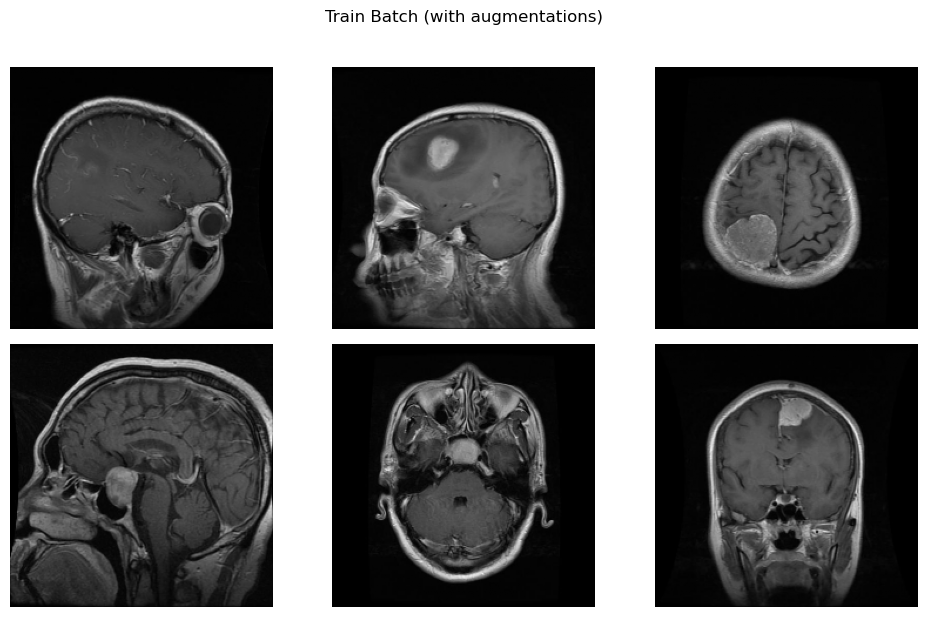

In [ ]:

'''def make_ds(dfx,dfy ,shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(  # dfx의 filepath, label_id 열을 사용해 tensor로 변환
        (dfx, dfy)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfx), seed=SEED, reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)  # augmentation이 필요하면 적용?
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)  # ds를 배치로 묶고, 다음 배치 미리 로드?? 성능 최적화??
    return ds'''

def apply_aug_pair(x, y):
    """
    이미지와 마스크를 채널 방향으로 합쳐서 동시에 증강하고 다시 분리합니다.
    가정: x는 3채널(RGB), y도 3채널(RGB Mask)이라고 가정합니다.
    """
    # 1. 이미지와 마스크 합치기 (Channel Concatenation)
    # x shape: (224, 224, 3), y shape: (224, 224, 3) -> combined: (224, 224, 6)
    combined = tf.concat([x, y], axis=-1)
    
    # 2. 증강 적용 (합쳐진 상태로 회전/이동하므로 완벽히 동기화됨)
    combined_aug = data_augmentation(combined, training=True)
    
    # 3. 다시 분리하기
    x_aug = combined_aug[:, :, :3]   # 앞 3개 채널은 이미지
    y_aug = combined_aug[:, :, 3:]   # 뒤 3개 채널은 마스크
    
    # [중요!] 마스크 보정
    # 회전/줌 과정에서 보간법(Interpolation) 때문에 마스크 값이 0.5, 0.3 등으로 변할 수 있습니다.
    # 다시 0 또는 1로 확실하게 잡아주기 위해 반올림을 하거나 threshold를 적용해야 합니다.
    y_aug = tf.round(y_aug) 
    
    return x_aug, y_aug

def make_ds(dfx, dfy, shuffle=False, augment=False):
    # 1. 파일 경로만 로드 (아직 이미지가 아님)
    # 실제로는 여기서 이미지를 읽어오는 map 함수가 먼저 필요할 수 있습니다. 
    # (현재 dfx가 이미 로드된 tensor인지 filepath인지에 따라 다르지만, 
    #  문맥상 이미 로드된 데이터라면 아래와 같이 씁니다.)
    
    ds = tf.data.Dataset.from_tensor_slices((dfx, dfy))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfx), seed=SEED, reshuffle_each_iteration=True)

    if augment:
        # [수정된 부분] x, y를 동시에 함수에 넣어 처리합니다.
        ds = ds.map(lambda x, y: apply_aug_pair(x, y), num_parallel_calls=AUTOTUNE)

    # 배치 및 프리페치 설정
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return ds

# Gentle, clinically plausible augmentations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), #수평
    tf.keras.layers.RandomRotation(10/360, fill_mode="constant", fill_value=0.0),  #10도 무작위 회전
    tf.keras.layers.RandomZoom(0.05, fill_mode="constant", fill_value=0.0), #0.05 줌인/줌아웃
    tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode="constant", fill_value=0.0), #가로세로 0.05 범위 내 무작위 이동
    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0)),  # 0.0- 1.0 범위로 픽셀값 제한.
], name="augmentation")  # aumentation layer sequence를 정의???

train_ds = make_ds(df_train,y_train, shuffle=True,  augment=False)  #일단 증강 안함
val_ds   = make_ds(df_val,y_val,   shuffle=False, augment=False)
test_ds  = make_ds(df_test,y_test,  shuffle=False, augment=False)

# Quick visual sanity check after augmentation
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy(), cmap="gray")
    plt.axis("off")
    cls_idx = tf.argmax(labels[i]).numpy()
    #plt.title(CLASSES[cls_idx])
plt.suptitle("Train Batch (with augmentations)", y=1.02)
plt.tight_layout()
plt.show()

In [7]:
#train autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 입력 정의 (예: 80x80x3 이미지)
input_img = Input(shape=(224, 224, 3))

# --- Encoder ---
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = BatchNormalization(name='encoded_output')(encoded)
#encoded =  MaxPooling2D((2, 2))(encoded)  #뭔가 이상

# --- Decoder ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
# decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(decoded)  


autoencoder_aug = Model(input_img, decoded)
autoencoder_aug.compile(optimizer='adam', loss='mse')
autoencoder_aug.summary()


# 1. 증강 옵션 정의 (이미지와 마스크에 공통 적용)
data_gen_args = dict(
    rotation_range=10,       # 0~15도 사이 랜덤 회전
    horizontal_flip=True,    # 좌우반전 허용
    vertical_flip=False,     # 상하반전 (필요시 True 변경)
    zoom_range=0.2,
    fill_mode='nearest'      # 회전 시 빈 공간 채우는 방식
)

# 2. 이미지용과 마스크용 제너레이터 각각 생성
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# 3. flow 메서드로 데이터 흐름 생성 (중요: seed를 동일하게 설정!)
# seed=42 (또는 임의의 정수)를 똑같이 주어야 난수 순서가 동기화됩니다.
seed = 42
batch_size = 8

image_generator = image_datagen.flow(
    X_trains, 
    batch_size=batch_size,
    seed=seed
)

mask_generator = mask_datagen.flow(
    y_train, 
    batch_size=batch_size,
    seed=seed
)

# 4. 두 제너레이터를 하나로 합치는 커스텀 제너레이터
def segmentation_generator(img_gen, mask_gen):
    # zip으로 묶어서 이미지와 마스크를 쌍으로 내보냄
    generator = zip(img_gen, mask_gen)
    
    for (img, mask) in generator:
        # 마스크 데이터는 회전/줌 과정에서 보간법에 의해 0과 1 사이의 소수점이 생길 수 있음
        # 필요하다면 아래처럼 임계값(threshold)을 적용하여 0 또는 1로 다시 맞춰줌 (이진 분류 시)
        # mask = (mask > 0.5).astype(float) 
        
        yield (img, mask)

# 5. 최종적으로 학습에 사용할 객체 생성
final_train_generator = segmentation_generator(image_generator, mask_generator)

# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=False)
model_checkpoint = ModelCheckpoint('segmentation_autoencoder.keras', monitor='val_loss', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 어떤 지표를 관찰할지 지정합니다 (일반적으로 검증 손실 'val_loss')
    factor=0.2,  # 학습률을 얼마나 감소시킬지 지정합니다 (새로운 LR = 기존 LR * factor)
    patience=10, # 이 지표가 몇 epoch 동안 개선되지 않을 때 학습률을 감소시킬지 지정합니다
    verbose=1, # 업데이트 메시지를 표시합니다
    mode='min',# 관찰 지표가 감소해야 개선으로 간주합니다 ('val_loss'의 경우 'min')
    min_lr=0.000001  # 학습률의 최소 하한선을 지정합니다
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_output                  │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 971,619 (3.71 MB)

 Trainable params: 969,123 (3.70 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# 1. GPU 메모리 정리 및 세션 초기화
K.clear_session()

# 2. 가비지 컬렉터 실행 (찌꺼기 메모리 삭제)
import gc
gc.collect()

print("✅ GPU 메모리 및 세션 초기화 완료")

✅ GPU 메모리 및 세션 초기화 완료


In [ ]:
#증강 option but can't
autoencoder_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint,reduce_lr]
)

Epoch 1/100


I0000 00:00:1764132561.209772  827399 service.cc:152] XLA service 0x78d51c030b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764132561.209794  827399 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-26 13:49:21.313060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764132561.828171  827399 cuda_dnn.cc:529] Loaded cuDNN version 90101
2025-11-26 13:49:23.360019: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-26 13:49:27.993615: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out

  1/197 ━━━━━━━━━━━━━━━━━━━━ 43:39 13s/step - loss: 1.0412

I0000 00:00:1764132572.062745  827399 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1452

2025-11-26 13:49:55.853077: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-26 13:49:58.755003: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1446

2025-11-26 13:50:04.148174: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-26 13:50:07.295173: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: saving model to segmentation_autoencoder.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - loss: 0.0407 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0055
Epoch 2: saving model to segmentation_autoencoder.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 0.0055 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0054
Epoch 3: saving model to segmentation_autoencoder.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - loss: 0.0054 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0051
Epoch 4: saving model to segmentation_autoencoder.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - loss: 0.0050 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0048
Epoch 5: saving model to segmentation_autoencoder.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 24

In [ ]:
# 증강 X
'''autoencoder_aug.fit(
    #simple_gen(),
    X_trains, y_train, 
    epochs=80,
    steps_per_epoch=len(X_train) // 16,
    validation_data=(X_vals,y_val),
    callbacks=[early_stopping, model_checkpoint,reduce_lr]
)'''

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0610911].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0718148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0516562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0776594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0492587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0653837].


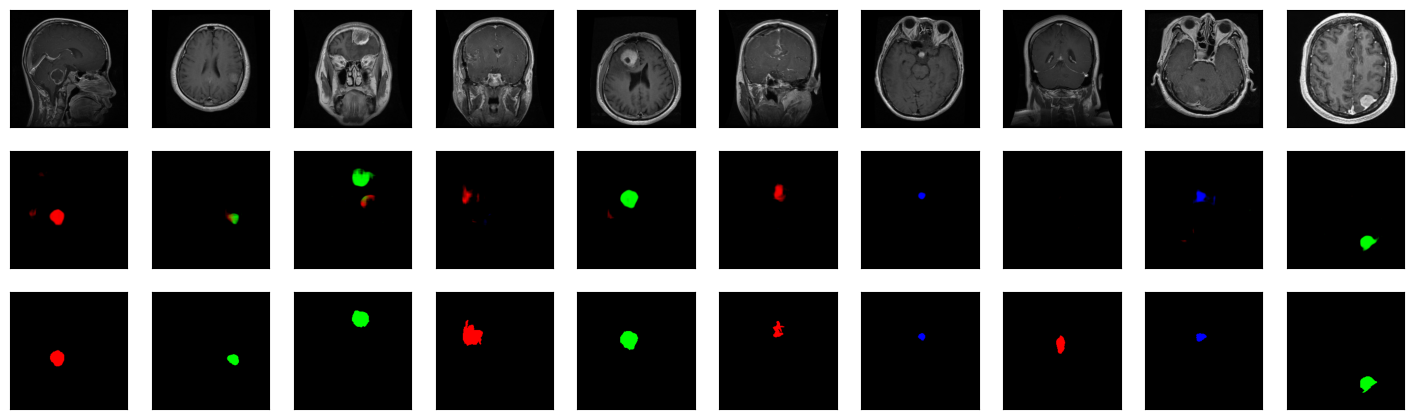

In [11]:
#check performance of autoencoder
autoencoder_aug.load_weights('segmentation_autoencoder.keras')
#decoded_val_images = autoencoder_aug.predict(X_vals)
decoded_test_images = autoencoder_aug.predict(X_tests)

n_images = 10
test_images = np.random.randint(0, X_tests.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # input images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_tests[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded val
  ax = plt.subplot(10,10, i + 1 + n_images )
  plt.imshow(decoded_test_images[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
   # Decoded val
  ax = plt.subplot(10,10, i + 1 + 2*n_images )
  plt.imshow(y_test[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
  

In [17]:
import numpy as np

def calculate_per_channel_metrics(y_true, y_pred, threshold=0.5, smooth=1e-6):
    """
    y_true: (H, W, 3) - 정답 이미지 1장
    y_pred: (H, W, 3) - 예측 이미지 1장
    반환값: 채널별 Dice list, 채널별 IoU list
    """
    num_channels = y_true.shape[-1] # 보통 3 (R, G, B)
    dice_scores = []
    iou_scores = []

    # 각 채널(Class)을 순회하며 개별 계산
    for i in range(num_channels):
        # i번째 채널만 슬라이싱 (H, W) 형태가 됨
        y_true_c = y_true[:, :, i]
        y_pred_c = y_pred[:, :, i]

        # 이진화 (Thresholding)
        y_pred_bin = (y_pred_c > threshold).astype(np.float32)
        y_true_bin = (y_true_c > threshold).astype(np.float32)

        # 1차원 평탄화
        y_true_f = y_true_bin.flatten()
        y_pred_f = y_pred_bin.flatten()

        # 교집합
        intersection = np.sum(y_true_f * y_pred_f)

        # Dice (채널 i)
        dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
        dice_scores.append(dice)

        # IoU (채널 i)
        union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
        iou = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou)

    return dice_scores, iou_scores

# --- 전체 Test Set 평가 실행 ---

# 결과 저장을 위한 리스트 (채널 수만큼 빈 리스트 생성)
n_classes = 3 # R, G, B
total_dice = [[] for _ in range(n_classes)]
total_iou = [[] for _ in range(n_classes)]

print(f"Evaluation start for {len(X_tests)} images (Multi-class Mode)...")

for i in range(len(X_tests)):
    # 이미지 한 장에 대해 채널별 점수 계산
    # decoded_test_images[i]는 모델 예측값
    d_list, i_list = calculate_per_channel_metrics(y_test[i], decoded_test_images[i])

    # 각 채널 리스트에 점수 추가
    for c in range(n_classes):
        total_dice[c].append(d_list[c])
        total_iou[c].append(i_list[c])

# --- 결과 출력 ---
print("="*40)
print(f" [Model Performance per Class (Channel)]")
print("-" * 40)

class_names = ["Red   (Ch 0, gl)", "Green (Ch 1, me)", "Blue  (Ch 2, pi)"] # 필요시 이름 변경하세요

mean_dices = []
mean_ious = []

for c in range(n_classes):
    m_dice = np.mean(total_dice[c])
    m_iou = np.mean(total_iou[c])
    mean_dices.append(m_dice)
    mean_ious.append(m_iou)

    print(f"{class_names[c]:<15} | Dice: {m_dice:.4f} | IoU: {m_iou:.4f}")

print("-" * 40)
print(f"Total Mean Dice : {np.mean(mean_dices):.4f}")
print(f"Total Mean IoU  : {np.mean(mean_ious):.4f}")
print("="*40)

Evaluation start for 860 images (Multi-class Mode)...
 [Model Performance per Class (Channel)]
----------------------------------------
Red   (Ch 0, gl) | Dice: 0.8495 | IoU: 0.8200
Green (Ch 1, me) | Dice: 0.8937 | IoU: 0.8721
Blue  (Ch 2, pi) | Dice: 0.8737 | IoU: 0.8409
----------------------------------------
Total Mean Dice : 0.8723
Total Mean IoU  : 0.8444


In [13]:
# --- Prediction and Visualization ---
output_dir = 'aug_segmentation'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

autoencoder_aug.load_weights('segmentation_autoencoder.keras')
decoded_test_images = autoencoder_aug.predict(X_tests)

num_test_images = X_tests.shape[0]
images_per_plot = 10

for i in range(0, num_test_images, images_per_plot):
    plt.figure(figsize=(18, 6))
    
    for j in range(images_per_plot):
        if i + j < num_test_images:
            image_index = i + j
            
            # Original Image
            ax = plt.subplot(3, images_per_plot, j + 1)
            plt.imshow(X_tests[image_index], cmap='gray')
            plt.xticks(())
            plt.yticks(())
            if j == 0:
                plt.ylabel('Original', fontsize=10)

            # Decoded Image
            ax = plt.subplot(3, images_per_plot, j + 1 + images_per_plot)
            plt.imshow(decoded_test_images[image_index], cmap='gray')
            plt.xticks(())
            plt.yticks(())
            if j == 0:
                plt.ylabel('Decoded', fontsize=10)

            # Ground Truth Mask
            ax = plt.subplot(3, images_per_plot, j + 1 + 2 * images_per_plot)
            plt.imshow(y_test[image_index], cmap='gray')
            plt.xticks(())
            plt.yticks(())
            if j == 0:
                plt.ylabel('Ground Truth', fontsize=10)

    plt.suptitle(f'Images {i} to {i + images_per_plot - 1}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    output_path = os.path.join(output_dir, f'segmentation_results_{i // images_per_plot}.png')
    plt.savefig(output_path)
    plt.close()
    print(f"Saved plot to {output_path}")

print("Processing complete.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0706692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.062364].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0684537].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0545652].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0170093].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0383359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0822808].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_0.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0710784].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1182543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0078896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0646302].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0861567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.096945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1335756].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_1.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0048801].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0298969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0453793].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.073322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0665355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0679487].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.133174].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_2.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0451165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0693733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0992448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1034826].


Saved plot to aug_segmentation/segmentation_results_3.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0449696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0671384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0272102].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2377256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0098674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0398684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.104291].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_4.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0316683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0297958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.09839].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.007712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0373975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.085712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.089712].
Clipping input data to the valid range 

Saved plot to aug_segmentation/segmentation_results_5.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1165348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0737625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1363417].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0717189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0910149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1273369].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0189353].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_6.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0515193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0709071].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0526915].


Saved plot to aug_segmentation/segmentation_results_7.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1038339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0837761].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0592898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1241544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0997559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0365171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0488176].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_8.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0546366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0778497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0936296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0852041].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0391353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0753003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1249858].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_9.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0890293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0143701].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0744132].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0729598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0365921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0609806].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0332782].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_10.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1471047].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0735549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0337896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0396944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0290049].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1020172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.128372].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_11.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0683658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0632559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0969409].


Saved plot to aug_segmentation/segmentation_results_12.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0600644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0663279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0319216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0772159].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0191821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0290303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1748562].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_13.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0276656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1721911].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1283802].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1264514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1057965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1141553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0856782].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_14.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1050904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1165035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0659136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1318786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1026908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.119762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0807462].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_15.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0909837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0237067].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1034621].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0331304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0239593].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.062305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0394051].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_16.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1456288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0897877].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0343738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0803226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0552807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0341848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.064196].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_17.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0644313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0369902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0495195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0004903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0881149].


Saved plot to aug_segmentation/segmentation_results_18.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0431725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1002212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.074978].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0664914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1075785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0244809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1029464].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_19.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0647901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0732117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0570801].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0846833].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0610911].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0871923].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1011581].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_20.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.139435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.087379].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0811872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0411797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1106174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0343041].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.074256].
Clipping input data to the valid rang

Saved plot to aug_segmentation/segmentation_results_21.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1232427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0686699].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1151617].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1020222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.060742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1462371].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0682706].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_22.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0492088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0469351].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0758665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0586035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0618188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.088679].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1813986].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_23.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0718625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.161173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0738885].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0618176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1019675].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.036312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0265486].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_24.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0711514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0447338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1133884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0678842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0942469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1585772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0258673].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_25.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0739552].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0846919].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0724711].


Saved plot to aug_segmentation/segmentation_results_26.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1265854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0447338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0346546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.033989].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0573783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.060197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1266123].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_27.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0413966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0514971].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0464344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0651991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1116704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0667735].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0589894].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_28.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1006274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0795].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0756437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0829403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1101577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1302965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.058933].
Clipping input data to the valid range

Saved plot to aug_segmentation/segmentation_results_29.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0789841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.102529].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0839155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0756165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0764198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0266587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0717591].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_30.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0598531].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0558491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0685114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0629113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.192623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0013958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0570936].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_31.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0590127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0428736].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0588411].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0818516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1982722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0401403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0590835].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_32.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.090751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1005744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0391016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.070785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0495603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0732479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0675905].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_33.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0332612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0764198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0735731].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0652461].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0734713].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0783921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0481771].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_34.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0894154].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0442903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0373225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0758836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0471117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0700952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.061354].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_35.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0728452].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0240182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0516562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1352916].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.058234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1509074].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0686088].


Saved plot to aug_segmentation/segmentation_results_36.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0448393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0233905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0624623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0653853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0818381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0782334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0482397].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_37.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0703875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1524959].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1753421].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0911795].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1413878].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0785491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.057144].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_38.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1248207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0822281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0223418].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0703888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0491217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0671216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.041704].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_39.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0440887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0993888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0873841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1808376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1105247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1105247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0581982].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_40.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.056037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0856998].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0368143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0664557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0952171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.107619].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1241107].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_41.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0537457].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0923194].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0490015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0523444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0461358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0527567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0673857].


Saved plot to aug_segmentation/segmentation_results_42.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0842913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0380806].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0423576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0010197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0535331].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.171215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0873164].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_43.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0844024].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0611068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0632929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0629045].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0749923].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0762466].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0622274].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_44.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0479727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0665854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0498492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0632546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0546033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0312781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0969718].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_45.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0605581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0522611].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0571458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0342267].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0643098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0729463].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1143705].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_46.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1050602].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0920031].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0698282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0408108].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0685039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0774586].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_47.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0586483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1264632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0340269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0663047].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0553657].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0993118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0965451].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_48.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0600275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0090512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0640984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.061157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1171111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0730217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1337725].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_49.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0837216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0848533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0430858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0734118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0677838].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.090698].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0950613].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_50.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0449419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0312723].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1299784].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.105117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.092891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.028286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0695688].
Clipping input data to the valid rang

Saved plot to aug_segmentation/segmentation_results_51.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0618871].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0834942].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0107762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0830736].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0773224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0983194].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1174654].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_52.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0205839].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0471662].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.062332].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0566918].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0770969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1091822].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.058757].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_53.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0831133].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0679529].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0759937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0374013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1109635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0354849].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0245262].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_54.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0216099].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0521723].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.045416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0115042].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1151608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0816995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0758793].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_55.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0675417].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0416225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0377342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0547359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0631955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0566463].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0658329].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_56.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0980312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0346507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0853751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.02856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0805981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.143024].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0251212].


Saved plot to aug_segmentation/segmentation_results_57.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0416465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0779358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0719626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.098901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1381993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.068639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0376424].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_58.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0282398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0994121].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.114661].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0218581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0689843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0119123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0391972].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_59.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.079624].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.061382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0357405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0248677].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0316793].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0367367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0910224].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_60.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0247157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0322034].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0840516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0336038].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0285836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0360211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0331247].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_61.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0409077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0230259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.032941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0345101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0971826].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0720592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.038509].


Saved plot to aug_segmentation/segmentation_results_62.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0457109].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0451249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0454249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0163249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.040858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0633714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1319325].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_63.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0317163].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0473517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0362748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0603079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0786607].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0323292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0371614].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_64.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0883517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0492587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.080831].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0776594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0282825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0635915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.020222].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_65.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0411619].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0387536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1471359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0129404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0244002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.029618].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0872093].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_66.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0626312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0964375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0448301].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1366072].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0221218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0700043].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1023197].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_67.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.044055].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0431103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0669376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1001323].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0587456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0357026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0229312].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_68.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1335415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.118692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.043182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0771701].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0604488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0691023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0828416].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_69.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0993662].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0557421].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0789047].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0779854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08071].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.051008].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.091868].
Clipping input data to the valid range

Saved plot to aug_segmentation/segmentation_results_70.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0681838].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0283381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0684879].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0249083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0522894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0708208].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.06584].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_71.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0894016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1038576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0862671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1160717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.09062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.131609].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0334913].
Clipping input data to the valid rang

Saved plot to aug_segmentation/segmentation_results_72.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1217829].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0700182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1079041].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0666804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.048494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0492655].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0077859].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_73.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0946206].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0530179].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0943084].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1163548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0917284].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0533153].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0525055].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_74.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0676433].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.045695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0688438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0840144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0224843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1388055].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1031593].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_75.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0663663].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0303434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1900524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0351236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0896393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0862229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0578117].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_76.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0899707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0923922].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1007314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0529343].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0734814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0750256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0600549].
Clipping input data to the valid r

Saved plot to aug_segmentation/segmentation_results_77.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.054399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0431491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0487078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0492134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.048507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.133991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0950793].
Clipping input data to the valid rang

Saved plot to aug_segmentation/segmentation_results_78.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0440443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1344206].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0774499].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0756373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.094228].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.101483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0585829].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_79.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0817028].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.033293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0691386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.042254].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0845023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0491582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0725908].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_80.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0788887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0488678].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0640655].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1289454].


Saved plot to aug_segmentation/segmentation_results_81.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.057668].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0634506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0810045].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.082042].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0525471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0459957].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1074048].
Clipping input data to the valid ran

Saved plot to aug_segmentation/segmentation_results_82.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0467504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0551081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0991327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0782559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0007771].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0481906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0916197].


Saved plot to aug_segmentation/segmentation_results_83.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.085872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0276506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0583549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0677543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0531063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0799205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0719155].
Clipping input data to the valid ra

Saved plot to aug_segmentation/segmentation_results_84.png
Saved plot to aug_segmentation/segmentation_results_85.png
Processing complete.
